<a href="https://colab.research.google.com/github/Dharanidharan2813/Zeotap_Assignement/blob/main/Zeotap_Assigment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')

## **Task 1 --- EDA Process**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   object        
 1   CustomerID       1000 non-null   object        
 2   ProductID        1000 non-null   object        
 3   TransactionDate  1000 non-null   datetime64[ns]
 4   Quantity         1000 non-null   int64         
 5   TotalValue       1000 non-null   float64       
 6   Price            1000 non-null   float64       
 7   Month            

<ipython-input-12-0ab27f6746bb>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  customers.fillna(method='ffill', inplace=True)


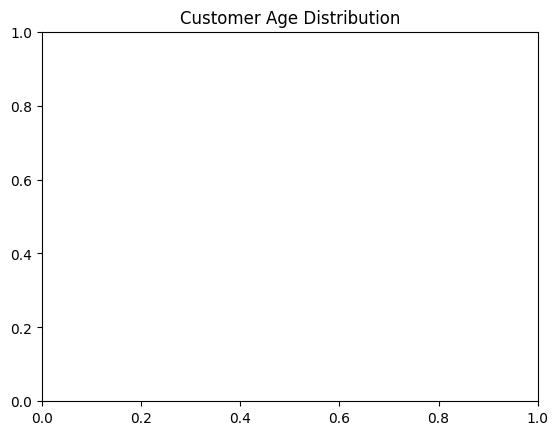

Top Products:
    ProductID           ProductName     Category   Price
21      P022    HomeSense Wall Art   Home Decor  137.54
28      P029    TechPro Headphones  Electronics  433.64
47      P048      TechPro Cookbook        Books  416.40
48      P049      TechPro Textbook        Books  147.95
53      P054    SoundWave Cookbook        Books   57.30
58      P059       SoundWave Jeans     Clothing  303.20
60      P061   HomeSense Desk Lamp   Home Decor  156.96
61      P062       HomeSense Novel        Books  374.16
78      P079        ActiveWear Rug   Home Decor  417.37
95      P096  SoundWave Headphones  Electronics  307.47


<Axes: title={'center': 'Monthly Sales'}, xlabel='Month'>

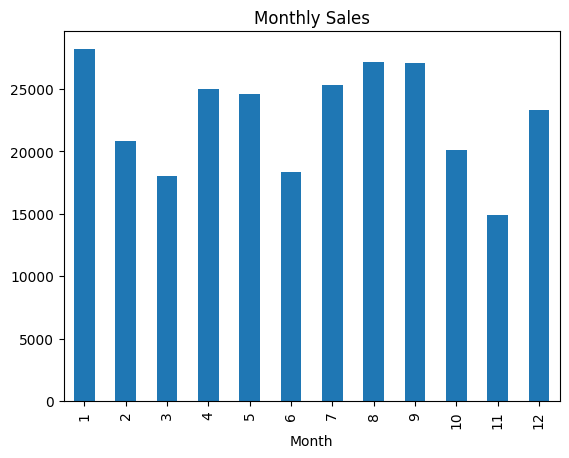

In [12]:
# ---------------- Task 1: EDA ---------------- #

print(customers.info(), transactions.info(), products.info())
print(customers.describe(), transactions.describe(), products.describe())

# Handle Missing Values
customers.fillna(method='ffill', inplace=True)
transactions.fillna(0, inplace=True)

# Visualize Customer Demographics
if 'AgeGroup' in customers.columns:
    sns.countplot(data=customers, x='AgeGroup')
elif 'age_group' in customers.columns:
    sns.countplot(data=customers, x='age_group')
else:
    print("Column 'AgeGroup' or similar not found in the DataFrame.")
    print("Available columns:", customers.columns.tolist())

plt.title('Customer Age Distribution')
plt.show()

# Analyze Product Popularity
product_sales = transactions['ProductID'].value_counts()
top_products = products.loc[products['ProductID'].isin(product_sales.index[:10])]
print("Top Products:\n", top_products)

# Analyze Spending Trends
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['Month'] = transactions['TransactionDate'].dt.month
monthly_sales = transactions.groupby('Month')['Price'].sum()
monthly_sales.plot(kind='bar', title='Monthly Sales')


## **Task 2 --- Lookalike Model**

In [14]:
# ---------------- Task 2: Lookalike Model ---------------- #

merged_data = pd.merge(customers, transactions, on='CustomerID')
customer_profiles = merged_data.groupby('CustomerID').agg({
    'Price': ['sum', 'mean'],
    'ProductID': 'count'
}).reset_index()
customer_profiles.columns = ['CustomerID', 'TotalSpent', 'AvgSpent', 'TotalTransactions']

# Normalize Data
scaler = StandardScaler()
features = scaler.fit_transform(customer_profiles[['TotalSpent', 'AvgSpent', 'TotalTransactions']])

# Calculate Similarities
similarity_matrix = cosine_similarity(features)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_profiles['CustomerID'], columns=customer_profiles['CustomerID'])

# Get Top 3 Similar Customers
lookalike_results = {}
for customer in customer_profiles['CustomerID']:
    similar_customers = similarity_df[customer].sort_values(ascending=False)[1:4]
    lookalike_results[customer] = similar_customers.to_dict()

# Save Lookalike Results
lookalike_df = pd.DataFrame([
    {'cust_id': k, 'similar_cust_id': sim_id, 'score': score}
    for k, v in lookalike_results.items() for sim_id, score in v.items()
])
lookalike_df.to_csv('Lookalike.csv', index=False)


## **Task 3 --- Customer Segmentation / Clustering**

Davies-Bouldin Index: 0.854282217917536


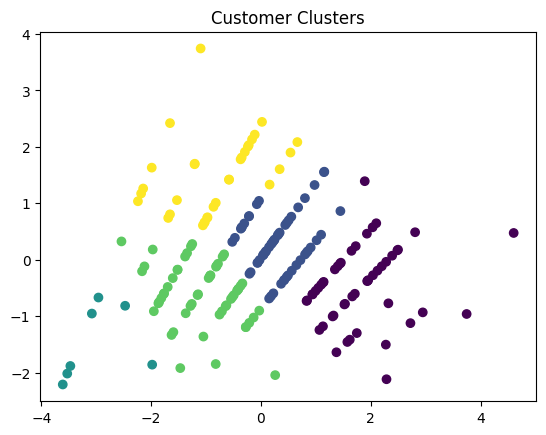

In [15]:
# ---------------- Task 3: Customer Segmentation ---------------- #

# Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(features)

# Evaluate Clustering
db_index = davies_bouldin_score(features, customer_profiles['Cluster'])
print("Davies-Bouldin Index:", db_index)

# Visualize Clusters
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=customer_profiles['Cluster'], cmap='viridis')
plt.title('Customer Clusters')
plt.show()

# Save Clustering Results
customer_profiles.to_csv('Customer_Segments.csv', index=False)